In [18]:
!pip install pycryptodome

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 96.1 MB/s eta 0:00:00


In [19]:
!pip install cryptography

### 1 - "Image Hash Ledger System (IHLS)".

Rationale for the Name:
"Image Hash": The system focuses on generating unique hash values for images, ensuring image authenticity.

"Ledger System": It uses a ledger (JSON file) to store and track image hashes, timestamps, and metadata, which helps in verifying image integrity and ownership.


Summary of How This Approach Works:
This system focuses on tracking image hashes in a ledger for verification and integrity purposes. It generates an SHA-256 hash for each image, allowing users to check whether an image is already recorded in the ledger. If the image hash doesn't exist, the system can optionally add the image hash to the ledger along with any metadata and a timestamp. This ensures that each image is uniquely identified and its integrity can be verified by comparing hashes in future checks.

This approach can be utilized for differentiating AI-generated images from real ones by adding the image hash to a ledger when the image is first acquired. If AI or manual tampering occurs, the hash will change, and the image can be flagged as altered. Vendors can update their acquisition and metadata processes by integrating automatic hash generation and ledger updating in the workflow. This enables full traceability and helps prevent fraudulent image submissions.

SHA-256 is a cryptographic hash function that produces a fixed-size, 256-bit hash value from arbitrary-length input data. It's part of the SHA-2 family and is widely used for verifying data integrity, especially in digital signatures and verifying transactions in blockchain technology like Bitcoin

In [20]:
import hashlib
import json
import os
from PIL import Image
import numpy as np
from datetime import datetime

ledger_path = "image_ledger.json"

def hash_image(image_path):
    img = Image.open(image_path).convert("L")
    img_bytes = np.asarray(img).tobytes()
    return hashlib.sha256(img_bytes).hexdigest()

def load_ledger(path):
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return []

def save_ledger(ledger, path):
    with open(path, "w") as f:
        json.dump(ledger, f, indent=4)

def check_hash_in_ledger(image_hash, ledger):
    for entry in ledger:
        if entry["hash"] == image_hash:
            return True, entry
    return False, None

def handle_image_hashing(image_path, metadata=None, hash_flag=1):
    if metadata is None:
        metadata = {}

    image_hash = hash_image(image_path)
    ledger = load_ledger(ledger_path)

    already_exists, existing_entry = check_hash_in_ledger(image_hash, ledger)

    if already_exists:
        print("✅ Image already exists in ledger.")
        print("🕒 Timestamp:", existing_entry['timestamp'])
        print("📄 Metadata:", existing_entry['metadata'])
        return

    print("❌ Image is NOT currently hashed.")
    print("Hash:", image_hash)

    if hash_flag == 1:
        new_entry = {
            "timestamp": datetime.utcnow().isoformat(),
            "hash": image_hash,
            "metadata": metadata
        }
        ledger.append(new_entry)
        save_ledger(ledger, ledger_path)
        print("🆕 Image hash has been saved to the ledger.")
    else:
        print("🚫 Skipping hashing as per user instruction (hash_flag=0).")


In [26]:
image_path = 'trial2.png'
metadata = {
    "source": "Your Source Name",
    "modality": "X Ray",
    "author": "John Doe"
}

handle_image_hashing(image_path, metadata, hash_flag=1)  # Hash and save
#handle_image_hashing(image_path, metadata, hash_flag=0)  # Just check




❌ Image is NOT currently hashed.
Hash: a9bf7187d7fff769af737b458969656622b963029b3c414b4334ec09e1a677f5
🆕 Image hash has been saved to the ledger.


In [27]:
# Re-run after hashing done.

image_path = 'trial2.png'
metadata = {
    "source": "Your Source Name",
    "modality": "X Ray",
    "author": "John Doe"
}

handle_image_hashing(image_path, metadata, hash_flag=1)  # Hash and save
#handle_image_hashing(image_path, metadata, hash_flag=0)  # Just check

✅ Image already exists in ledger.
🕒 Timestamp: 2025-08-20T21:04:42.008887
📄 Metadata: {'source': 'Your Source Name', 'modality': 'X Ray', 'author': 'John Doe'}


### 2 - “RSA-Secure Imaging Signature (RSIS)”.

Why this name?
"RSA-Secure": It’s built on RSA public-private key cryptography.

"Imaging Signature": It signs image files using a cryptographic hash and validates their integrity and authenticity—ideal for clinical or AI-sensitive imaging contexts.



In [28]:
from Crypto.PublicKey import RSA
from Crypto.Signature import pkcs1_15
from Crypto.Hash import SHA256
import os

# ---🔐 1. KEY GENERATION ---
# Generate RSA public-private key pair (only once per user/system)
key = RSA.generate(2048)  # 2048-bit key strength
private_key = key.export_key()  # Export private key in PEM format (bytes)
public_key = key.publickey().export_key()  # Export corresponding public key

# ---💾 2. SAVE KEYS TO FILES (Optional but recommended) ---
with open("private.pem", "wb") as f:
    f.write(private_key)
with open("public.pem", "wb") as f:
    f.write(public_key)

# ---✍️ 3. SIGN IMAGE FUNCTION ---
def sign_image(image_path, private_key_pem, save_to_file=True):
    img_hash = SHA256.new(open(image_path, 'rb').read())
    private_key = RSA.import_key(private_key_pem)
    signature = pkcs1_15.new(private_key).sign(img_hash)

    if save_to_file:
        sig_path = image_path + ".sig"
        with open(sig_path, "wb") as f:
            f.write(signature)
        print(f"📝 Signature saved to {sig_path}")

    return signature

# ---✅ 4. VERIFY SIGNATURE FUNCTION ---
def verify_signature(image_path, signature, public_key_pem):
    """
    Verifies the signature of the image using the public RSA key.
    Returns True if valid, False otherwise.
    """
    # Recompute the hash of the image
    img_hash = SHA256.new(open(image_path, 'rb').read())

    # Import public key from PEM
    public_key = RSA.import_key(public_key_pem)

    try:
        # Verify if signature matches the image hash
        pkcs1_15.new(public_key).verify(img_hash, signature)
        return True
    except (ValueError, TypeError):
        return False

# ---🧪 5. USAGE FUNCTION WITH sign_flag CONTROL ---
def process_image_signature(image_path, sign_flag=1):
    """
    Allows user to choose whether to digitally sign the image.
    - sign_flag = 1: Sign and verify the image.
    - sign_flag = 0: Skip signing and just load keys.
    """
    if not os.path.exists(image_path):
        print("🚫 Image path does not exist.")
        return

    if sign_flag == 1:
        print("🔐 Signing image...")
        signature = sign_image(image_path, private_key)
        
        print("✅ Signature created. Now verifying...")
        is_valid = verify_signature(image_path, signature, public_key)
        
        print("✅ Signature valid:", is_valid)
    else:
        print("ℹ️ Skipping signing. Keys loaded but no action taken.")

def is_image_signed(image_path, public_key_pem):
    """
    Checks if an image is digitally signed and the signature is valid.
    Assumes the signature file is saved as 'image_path.sig'
    """
    sig_path = image_path + ".sig"

    if not os.path.exists(sig_path):
        print("🔍 No signature file found for:", image_path)
        return False

    with open(sig_path, "rb") as f:
        signature = f.read()

    is_valid = verify_signature(image_path, signature, public_key_pem)
    if is_valid:
        print("✅ Image is signed and the signature is valid.")
    else:
        print("⚠️ Signature file found, but it's NOT valid!")

    return is_valid





In [29]:
image_path = "trial1.jpg"
process_image_signature(image_path, sign_flag=1)  # Change to 0 to skip signing

🔐 Signing image...
📝 Signature saved to trial1.jpg.sig
✅ Signature created. Now verifying...
✅ Signature valid: True


In [30]:
# Use this to check if an image is signed:
image_path = "trial1.jpg"
is_signed = is_image_signed(image_path, public_key)

✅ Image is signed and the signature is valid.


In [31]:
# Use this to check if an image is signed:
image_path = "trial2.jpg"
is_signed = is_image_signed(image_path, public_key)

🔍 No signature file found for: trial2.jpg


In [32]:
# Use this to check if an image is signed:
image_path = "trial3.jpg"
is_signed = is_image_signed(image_path, public_key)

🔍 No signature file found for: trial3.jpg


### 3 - “Dual-Layer Watermarking for Medical Imaging Authentication (DLW-MIA)”.

Why this name?
"Dual-Layer": It uses both invisible (LSB-embedded) and visible (overlay text) watermarking methods.

"Watermarking": The core function is to mark the image in a reversible but tamper-evident way.

"for Medical Imaging Authentication": Clearly defines the use case—ensuring authenticity and traceability in radiology, diagnostic, and AI-augmented imaging workflows.

In [33]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

def embed_watermark(image_path, watermark_text, output_path, watermark_flag=1, show_indicator=True):
    """
    Embeds a hidden watermark via LSB, and optionally overlays a visible watermark indicator.
    """
    img = Image.open(image_path).convert("L")
    pixels = np.array(img)

    if watermark_flag == 0:
        img.save(output_path)
        print("ℹ️ Watermarking skipped. Original image saved as:", output_path)
        return

    # Hidden watermark encoding (LSB)
    watermark_bin = ''.join([format(ord(c), '08b') for c in watermark_text]) + '00000000'
    total_bits = len(watermark_bin)
    flat_pixels = pixels.flatten()

    if total_bits > len(flat_pixels):
        raise ValueError("🚫 Watermark too long for image size!")

    for i in range(total_bits):
        flat_pixels[i] = (flat_pixels[i] & ~1) | int(watermark_bin[i])

    watermarked_img = Image.fromarray(flat_pixels.reshape(pixels.shape))

    # Add visible watermark indicator if flag is set
    if show_indicator:
        watermarked_img = watermarked_img.convert("RGB")  # Convert to RGB for drawing
        draw = ImageDraw.Draw(watermarked_img)
        try:
            # Try loading a nicer font if available
            font = ImageFont.truetype("arial.ttf", size=24)
        except:
            font = ImageFont.load_default()

        text = "Watermarked Image"
        text_position = (10, 10)
        draw.text(text_position, text, fill=(255, 0, 0), font=font)  # Red text

    watermarked_img.save(output_path)
    print("✅ Watermark embedded with indicator saved to:", output_path)
    
    
def extract_watermark(image_path, max_chars=100):
    """
    Extracts hidden LSB-based watermark text from a grayscale image.

    Args:
        image_path (str): Path to the watermarked image.
        max_chars (int): Max number of characters to extract (default 100).

    Returns:
        str: The extracted watermark text.
    """
    img = Image.open(image_path).convert("L")
    pixels = np.array(img).flatten()

    bits = [str(p & 1) for p in pixels[:max_chars * 8]]  # Read bits
    chars = [chr(int(''.join(bits[i:i+8]), 2)) for i in range(0, len(bits), 8)]

    watermark = ''.join(chars).split('\x00')[0]  # Stop at null char
    return watermark


In [34]:
embed_watermark(
    image_path=r"trial2.png",
    watermark_text="2025_ABCDEFG",
    output_path="watermarked_with_label_trial2.png",
    watermark_flag=1,
    show_indicator=True  # Set to False to hide the visible label
)


✅ Watermark embedded with indicator saved to: watermarked_with_label_trial2.png


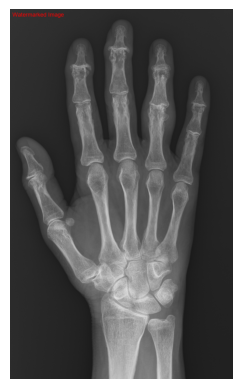

In [35]:
import matplotlib.pyplot as plt
img = Image.open("watermarked_with_label_trial2.png")
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')  # Hide axes
plt.show()

In [36]:
extracted_text = extract_watermark("watermarked_with_label_trial2.png")
print("🕵️ Extracted Watermark:", extracted_text)

🕵️ Extracted Watermark: 2025_ABCDEFG


In [37]:
image_path="trial2.png"
extracted_text = extract_watermark(image_path)
print("🕵️ Extracted Watermark:", extracted_text)

🕵️ Extracted Watermark: Þl!ßIèmÅ|¿ïÿÏv]¸Lì:¬ËxúÝo²Jà"¸!/í;Vo¨T<]}C5Î'^|çÌ°ç ñÛ±ãüþoÚþN?Ïª¤¿Ï·í¶


# 4 -"Flexible Provenance Ledger for Medical Images" (FPL-MI).

Why this name?
"Flexible" – because it allows both hashed and non-hashed identifiers (e.g., for use cases where full hashing isn't practical, such as previews, proxies, or early-stage pipelines).

"Provenance Ledger" – because the primary purpose is to record and verify the origin and authenticity of medical images over time.

"for Medical Images" – to specify its intended use case in clinical, radiological, or imaging workflows.


In [38]:
import json
import os
from datetime import datetime
from hashlib import sha256

# Path to the ledger file
ledger_path = "image_ledger1.json"

def hash_image(image_path):
    """Generates a SHA-256 hash for the given image file."""
    with open(image_path, "rb") as f:
        return sha256(f.read()).hexdigest()

def write_to_ledger(image_path, metadata, use_hash=True):
    """
    Writes a new image entry to the ledger with or without hashing.

    Args:
        image_path (str): Path to the image file.
        metadata (dict): Metadata such as source, location, etc.
        use_hash (bool): If True, hash the image. If False, use file name as identifier.
    """
    # Generate hash or fallback to filename
    image_identifier = hash_image(image_path) if use_hash else os.path.basename(image_path)

    # Load existing ledger or create a new one
    if os.path.exists(ledger_path):
        with open(ledger_path, "r") as f:
            try:
                ledger = json.load(f)
            except json.JSONDecodeError:
                print("⚠️ Warning: Ledger is corrupted. Creating a new one.")
                ledger = []
    else:
        ledger = []

    # Create the ledger entry
    entry = {
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "hash": image_identifier,
        "metadata": metadata,
        "hashed": use_hash  # Track if hash or filename was used
    }

    # Save the entry
    ledger.append(entry)
    with open(ledger_path, "w") as f:
        json.dump(ledger, f, indent=4)
    
    print(f"✅ Entry added to ledger for {'hash' if use_hash else 'filename'}: {image_identifier}")

def check_hash_in_ledger(image_hash):
    """
    Checks if a hash or identifier exists in the ledger.

    Args:
        image_hash (str): SHA-256 hash or filename to check.

    Returns:
        bool: True if found, False otherwise.
    """
    if not os.path.exists(ledger_path):
        print("ℹ️ Ledger does not exist yet.")
        return False

    with open(ledger_path, "r") as f:
        try:
            ledger = json.load(f)
        except json.JSONDecodeError:
            print("⚠️ Ledger is corrupted.")
            return False

    for entry in ledger:
        if entry["hash"] == image_hash:
            print("🔍 Match found in ledger.")
            return True
    
    print("❌ Not found in ledger.")
    return False


In [39]:
image_path = "trial3.jpg"
metadata = {
    "source": "MR Scanner",
    "location": "Your Institution Name",
    "modality": "MRI",
    "operator": "John Doe"
}

# Choose to hash or not
use_hash = False  # Change to False to use just the filename

write_to_ledger(image_path, metadata, use_hash=use_hash)

# Check using hash or filename depending on what was used
identifier = hash_image(image_path) if use_hash else os.path.basename(image_path)
is_registered = check_hash_in_ledger(identifier)
print("🧾 Registered in ledger?", is_registered)


✅ Entry added to ledger for filename: trial3.jpg
🔍 Match found in ledger.
🧾 Registered in ledger? True


In [40]:
image_path = "trial2.png"
metadata = {
    "source": "X-Ray",
    "location": "Your Institution Name",
    "modality": "X-Ray",
    "operator": "John Doe"
}

# Choose to hash or not
use_hash = True  # Change to False to use just the filename

write_to_ledger(image_path, metadata, use_hash=use_hash)

# Check using hash or filename depending on what was used
identifier = hash_image(image_path) if use_hash else os.path.basename(image_path)
is_registered = check_hash_in_ledger(identifier)
print("🧾 Registered in ledger?", is_registered)


✅ Entry added to ledger for hash: 6f10ab4358520cc84c53223996e06842b82eb97c34f2f04afcf9fa63b3246aaf
🔍 Match found in ledger.
🧾 Registered in ledger? True
